In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("model_inference", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import psutil
import tracemalloc
from parse_dataset import NetworkDataset, parse_dataset, split_datasets
from model import Model
from load_models import models

In [2]:
conf = {
    "batch_size": 516,
    "epochs": 10,
    "learning_rate": 0.0001
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd().replace("model_inference", ""), "datasets", "network_packet_data_test.csv")
data, labels, label_dict = parse_dataset(network_data_file)

# split dataset into train, val and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
print(X_train.shape)
print(y_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513])
torch.Size([356334])


In [5]:
X_test2 = X_test.unsqueeze(-1)
print(X_test2.shape)
print(y_test.shape)

test_dataset2 = NetworkDataset(X_test2, y_test)
test_loader2 = DataLoader(test_dataset2, batch_size=conf["batch_size"])

torch.Size([101811, 513, 1])
torch.Size([101811])


In [6]:
class Benchmark:
    def __init__(self, model, model_path):
        self.model = model
        self.model.load(model_path)
        self.process = psutil.Process(os.getpid())
    
    def run(self, loader):
        """Run benchmark measuring model accuracy, cpu time, memory usage and total runtime"""
        tracemalloc.start()
        start_time = time.time()
        _, accuarcy = self.model.evaluate(loader)
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        total_runtime = end_time - start_time
        memory_usage = peak / 1024**2 # MB
        cpu_usage = self.process.cpu_percent(interval=total_runtime)

        return accuarcy, cpu_usage, memory_usage, total_runtime

In [11]:
performance ={
    "acc": [],
    "cpu": [],
    "mem": [],
    "time": []

}

model_id = {}

i = 0
for model_name in models.keys():
    model_id[model_name] = i
    i += 1

    model = models[model_name]
    file = model_name + "_model.pth"
    path = os.path.join(os.getcwd().replace("model_inference", ""), "checkpoint", file)
    benchmark = Benchmark(model, path)

    loader = test_loader2
    if model_name == "mlp" or model_name == "light_mlp":
        loader = test_loader
    
    acc, cpu, mem, runtime = benchmark.run(loader=loader)
    performance["acc"].append(acc)
    performance["cpu"].append(cpu)
    performance["mem"].append(mem)
    performance["time"].append(runtime)
    
    print(f"Benchmark ({model_name}): Accuracy: {100*acc:.2f}%, CPU Usage: {cpu:.2f}%, Memory Usage: {mem:.2f}MB, Runtime: {runtime:.2f}s")


Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/mlp_model.pth!
Benchmark (mlp): Accuracy: 85.95%, CPU Usage: 0.00%, Memory Usage: 13.31MB, Runtime: 1.67s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_mlp_model.pth!
Benchmark (light_mlp): Accuracy: 77.63%, CPU Usage: 26.00%, Memory Usage: 0.19MB, Runtime: 1.61s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/lstm_model.pth!
Benchmark (lstm): Accuracy: 97.15%, CPU Usage: 0.20%, Memory Usage: 0.19MB, Runtime: 133.36s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_lstm_model.pth!
Benchmark (light_lstm): Accuracy: 91.05%, CPU Usage: 3.30%, Memory Usage: 0.19MB, Runtime: 8.60s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/gru_model.pth!
Benchmark (gru): Accuracy: 96.94%, CPU Usage: 0.10%, Memory Usage: 0.21MB, Runtime: 321.29s
Checkpoint loaded from /home/jo

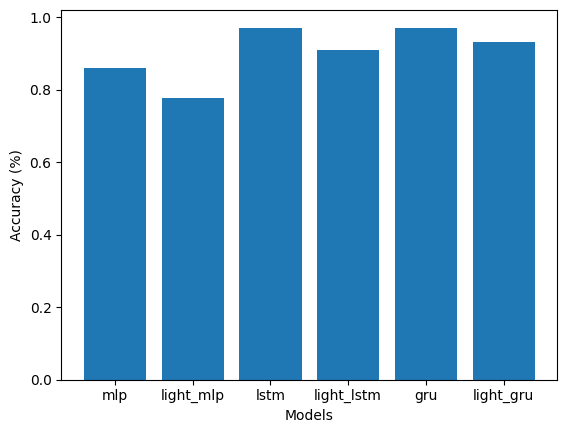

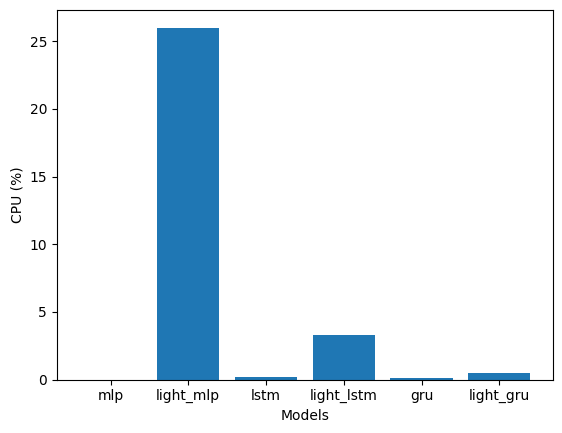

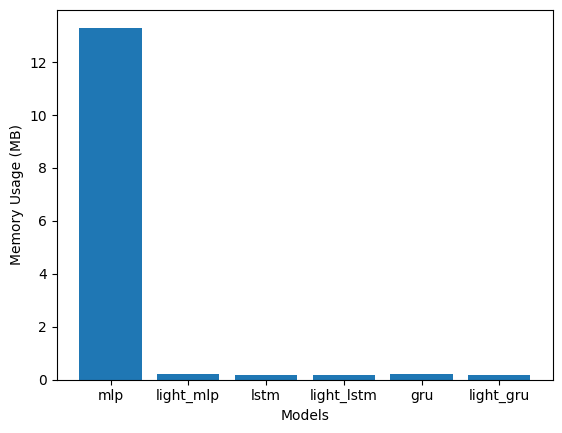

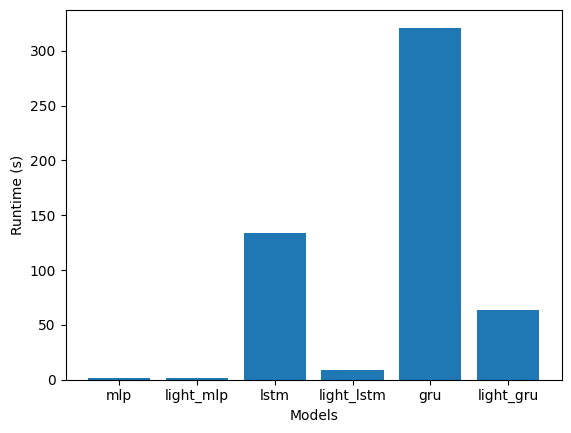

In [ ]:
model_names = list(model_id.keys())

for data_type in performance.keys():
    plt.bar(model_names, performance[data_type])
    plt.xlabel("Models")
    y_value = ""
    if data_type == "acc":
        y_value = "Accuracy (%)"
    elif data_type == "cpu":
        y_value = "CPU (%)"
    elif data_type == "mem":
        y_value = "Memory Usage (MB)"
    else:
        y_value = "Runtime (s)"
    
    plt.ylabel(y_value)
    plt.show()